In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Peak in sensitivity persists in renewed data - can we get rid of it with alternative starting states?

# Imports

In [15]:
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.misc.units import per_mol_to_per_molecule
from synbio_morpher.utils.common.setup import prepare_config, construct_circuit_from_cfg
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.circuit.agnostic_circuits.circuit_manager import CircuitModeller
from synbio_morpher.srv.io.manage.script_manager import script_preamble
from synbio_morpher.utils.circuit.agnostic_circuits.circuit_manager import CircuitModeller



# Analysis of generated data

1. What is the value of the sensitivity peak ($s_{peak}$)?
2. Which circuits get an $s_{peak}$?
3. What does the peak depend on? Could it be...
    - Forward rate
    - Initial state
    - Value of signal input
4. Is there a better way of simulating circuits where some components have no interaction? Can we assign a zero rate in both directions??

## Load data

In [16]:
fn = '../data/ensemble_mutation_effect_analysis/2024_11_11_135219/summarise_simulation/tabulated_mutation_info.csv'
data = pd.read_csv(fn)
data

,circuit_name,mutation_name,mutation_num,mutation_type,mutation_positions,path_to_template_circuit,index,sample_num,name,interacting,...,initial_steady_states,max_amount,min_amount,overshoot,RMSE,steady_states,response_time_wrt_species-6,precision_wrt_species-6,sensitivity_wrt_species-6,sample_name
0,toy_mRNA_circuit_0,ref_circuit,0,[],[],./data/ensemble_mutation_effect_analysis/2024_...,0.0,9.0,toy_mRNA_circuit_0,[],...,199.73235,400.0,199.73235,0.802002,0.000000,399.19800,0.0,1.004021,1.000000,RNA_0
1,toy_mRNA_circuit_0,ref_circuit,0,[],[],./data/ensemble_mutation_effect_analysis/2024_...,0.0,9.0,toy_mRNA_circuit_0,[],...,199.73235,200.0,199.66568,0.000000,0.000000,199.66568,0.0,3004.060800,0.000333,RNA_1
2,toy_mRNA_circuit_0,ref_circuit,0,[],[],./data/ensemble_mutation_effect_analysis/2024_...,0.0,9.0,toy_mRNA_circuit_0,[],...,199.73235,200.0,199.66568,0.000000,0.000000,199.66568,0.0,3004.060800,0.000333,RNA_2
3,toy_mRNA_circuit_0,RNA_0_m1-0,1,[3],[18],./data/ensemble_mutation_effect_analysis/2024_...,0.0,9.0,toy_mRNA_circuit_0,[],...,199.73235,400.0,199.73235,0.802002,0.000000,399.19800,0.0,1.004021,1.000000,RNA_0
4,toy_mRNA_circuit_0,RNA_0_m1-0,1,[3],[18],./data/ensemble_mutation_effect_analysis/2024_...,0.0,9.0,toy_mRNA_circuit_0,[],...,199.73235,200.0,199.66568,0.000000,0.000000,199.66568,0.0,3004.060800,0.000333,RNA_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6295,toy_mRNA_circuit_99,RNA_2_m1-0,1,[8],[9],./data/ensemble_mutation_effect_analysis/2024_...,4.0,9.0,toy_mRNA_circuit_99,[],...,199.73235,200.0,199.66568,0.000000,0.000000,199.66568,0.0,3004.060800,0.000333,RNA_1
6296,toy_mRNA_circuit_99,RNA_2_m1-0,1,[8],[9],./data/ensemble_mutation_effect_analysis/2024_...,4.0,9.0,toy_mRNA_circuit_99,[],...,199.73235,200.0,199.66568,0.000000,0.000000,199.66568,0.0,3004.060800,0.000333,RNA_2
6297,toy_mRNA_circuit_99,RNA_2_m1-1,1,[2],[14],./data/ensemble_mutation_effect_analysis/2024_...,5.0,9.0,toy_mRNA_circuit_99,[[1 2]],...,199.74307,400.0,199.74307,0.780518,0.021447,399.21948,0.0,1.003913,1.000000,RNA_0
6298,toy_mRNA_circuit_99,RNA_2_m1-1,1,[2],[14],./data/ensemble_mutation_effect_analysis/2024_...,5.0,9.0,toy_mRNA_circuit_99,[[1 2]],...,192.17154,200.0,192.11177,0.000000,7.546352,192.11177,0.0,3223.526400,0.000310,RNA_1


## Value of sensitivity peak

The sensitivity peak is at 0.00033288274


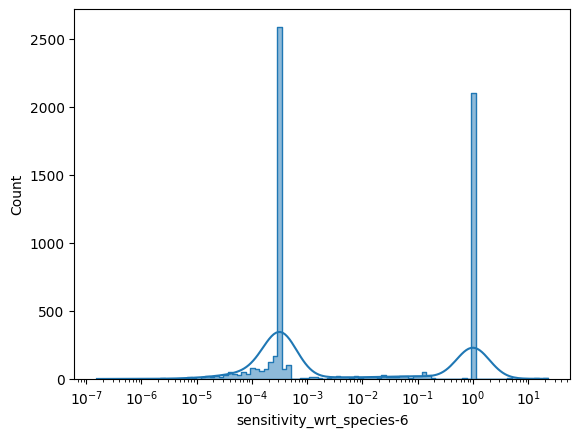

In [17]:
sns.histplot(data, x='sensitivity_wrt_species-6', bins=100, element='step', log_scale=[True, False], kde=True)
s_peak = data['sensitivity_wrt_species-6'].median()
print(f'The sensitivity peak is at {s_peak}')

## Circuits that have the $s_{peak}$

Once again, the circuits at the sensitivity peak are the ones where none of the RNAs are interacting, aka 'null circuits'.

In [18]:
cols_e = get_true_interaction_cols(data, 'energies')
data[data['sensitivity_wrt_species-6'] == s_peak][['circuit_name'] + cols_e].iloc[:5]

,circuit_name,energies_0-0,energies_0-1,energies_0-2,energies_1-0,energies_1-1,energies_1-2,energies_2-0,energies_2-1,energies_2-2
1,toy_mRNA_circuit_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,toy_mRNA_circuit_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,toy_mRNA_circuit_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,toy_mRNA_circuit_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,toy_mRNA_circuit_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
cols_brd = get_true_interaction_cols(data, 'binding_rates_dissociation')
data[data['sensitivity_wrt_species-6'] == s_peak][['circuit_name'] + cols_brd].iloc[:5]

,circuit_name,binding_rates_dissociation_0-0,binding_rates_dissociation_0-1,binding_rates_dissociation_0-2,binding_rates_dissociation_1-0,binding_rates_dissociation_1-1,binding_rates_dissociation_1-2,binding_rates_dissociation_2-0,binding_rates_dissociation_2-1,binding_rates_dissociation_2-2
1,toy_mRNA_circuit_0,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995
2,toy_mRNA_circuit_0,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995
4,toy_mRNA_circuit_0,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995
5,toy_mRNA_circuit_0,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995
7,toy_mRNA_circuit_0,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995


# What does the peak depend on?

Let's construct a bunch of null circuits that have different starting states, forward rates, and signal targets.
Forward rates are usually 1e6 per mol, so we can try different rates like 1e3 to 1e10. These have to be converted to per molecule.

In [20]:
config = load_json_as_dict('../synbio_morpher/utils/common/testing/configs/simple_circuit.json')

k_a_og = 0.00150958097
forward_rates = jax.tree_util.tree_map(per_mol_to_per_molecule, jnp.power(10, np.arange(3, 10, 0.5)))
starting_states_all = np.arange(10, 310, 20)
starting_states_all = np.concatenate([starting_states_all[:, None] * np.ones((len(starting_states_all), 3)), np.random.randint(10, 300, (len(starting_states_all), 3))])
signal_targets = np.concatenate([np.arange(0.1, 2, 0.1), np.arange(2, 4, 0.5), np.arange(4, 8, 1)])

print(f'There are a total of {len(starting_states_all) * len(forward_rates) * len(signal_targets)} simulations to run')


There are a total of 11340 simulations to run


In [ ]:
config = prepare_config(config)
config['include_prod_deg'] = False
config['simulation']['batch_size'] = 500
config['simulation']['device'] = 'cpu'
config['simulation']['dt0'] = 0.005
config['simulation']['dt1'] = 0.005 / 2
config['simulation']['t0'] = 0
config['simulation']['t1'] = 500
config['simulation']['tmax'] = 1500
config['simulation']['use_initial_to_add_signal'] = False
config['simulation']['use_rate_scaling'] = True
config['signal']['function_kwargs']['target'] = 2


[cuda(id=0), cuda(id=1)]

In [9]:
def load_circuit(k_a, energies, eqconstants, starting_states, signal_target):
    c = {'data_path': data[data['sensitivity_wrt_species-6'] == s_peak]['path_to_template_circuit'].iloc[0].replace('./', '../'),
        #  'molecular_params': config['molecular_params'],
         'signal': config['signal']}
    c['signal']['function_kwargs']['target'] = signal_target
    # c['molecular_params']['starting_copynumbers'] = np.mean(starting_states)
    
    circuit = construct_circuit_from_cfg(c, config)
    circuit.interactions.energies = energies
    circuit.interactions.eqconstants = eqconstants
    circuit.interactions.binding_rates_association = k_a
    circuit.interactions.binding_rates_dissociation = eqconstants / k_a
    if type(starting_states) == np.ndarray:
        for i, (s, r) in enumerate(zip(starting_states, circuit.qreactions.reactants)):
            circuit.qreactions.reactants[i].quantity = s
    return circuit


energies = data[data['sensitivity_wrt_species-6']
                == s_peak][cols_e].iloc[0].values
eqconstants = data[data['sensitivity_wrt_species-6'] ==
                   s_peak][get_true_interaction_cols(data, 'eqconstants')].iloc[0].values
circuits = []
data_circuits = pd.DataFrame(columns=['circuit_name', 'k_a', 'starting_state', 'signal_target', 'circuit'])
for i, (k_a, starting_state, signal_target) in enumerate(itertools.product(forward_rates, starting_states_all, signal_targets)):
    circuit = load_circuit(k_a, energies, eqconstants, starting_state, signal_target)
    name = f'RNA_circuit_{i}'
    circuit.name = name
    data_circuits.loc[i] = [name, k_a, starting_state, signal_target, circuit]
    circuits.append(circuit)

In [10]:
data_circuits

,circuit_name,k_a,starting_state,signal_target,circuit
0,RNA_circuit_0,0.000002,"[10.0, 10.0, 10.0]",0.1,<synbio_morpher.utils.circuit.agnostic_circuit...
1,RNA_circuit_1,0.000002,"[10.0, 10.0, 10.0]",0.2,<synbio_morpher.utils.circuit.agnostic_circuit...
2,RNA_circuit_2,0.000002,"[10.0, 10.0, 10.0]",0.3,<synbio_morpher.utils.circuit.agnostic_circuit...
3,RNA_circuit_3,0.000002,"[10.0, 10.0, 10.0]",0.4,<synbio_morpher.utils.circuit.agnostic_circuit...
4,RNA_circuit_4,0.000002,"[10.0, 10.0, 10.0]",0.5,<synbio_morpher.utils.circuit.agnostic_circuit...
...,...,...,...,...,...
11335,RNA_circuit_11335,4.773714,"[36.0, 271.0, 276.0]",3.5,<synbio_morpher.utils.circuit.agnostic_circuit...
11336,RNA_circuit_11336,4.773714,"[36.0, 271.0, 276.0]",4.0,<synbio_morpher.utils.circuit.agnostic_circuit...
11337,RNA_circuit_11337,4.773714,"[36.0, 271.0, 276.0]",5.0,<synbio_morpher.utils.circuit.agnostic_circuit...
11338,RNA_circuit_11338,4.773714,"[36.0, 271.0, 276.0]",6.0,<synbio_morpher.utils.circuit.agnostic_circuit...


# Run simulation

In [11]:
config, result_writer = script_preamble(
    config=config, data_writer=None)
circuit_modeller = CircuitModeller(result_writer=result_writer, config=config)


In [12]:
circuits = circuit_modeller.batch_circuits(
    circuits=circuits, 
    batch_size=config['simulation']['batch_size'],
    methods={
        "compute_interactions": {},
        "init_circuits": {'batch': True},
        'simulate_signal_batch': {'ref_circuit': None,
                                  'batch': config['simulation']['use_batch_mutations']},
        'write_results': {'no_visualisations': False, # config['experiment']['no_visualisations'],
                          'no_numerical': False} #config['experiment']['no_numerical']}
    }
)

circuit_manager.py:batch_circuits():600: 	From 11340 circuits, a total of 11340 mutated circuits will be simulated. WARNING
circuit_manager.py:batch_circuits():607: 		Starting new round of viable circuits (0 - 999 / 11340) WARNING
circuit_manager.py:batch_circuits():627: 		Making subcircuits 0 - 999 took 0.001144s WARNING
circuit_manager.py:batch_circuits():633: 	Batching 0 - 2000 circuits (out of 0 - 999 (total: 11340)) (Circuits: 0 - 999 of 11340) WARNING
circuit_manager.py:run_batch():665: 		Running 999 Subcircuits - RNA_circuit_0: compute_interactions WARNING


circuit_manager.py:run_batch():701: 		Method compute_interactions took 119.83503s WARNING
circuit_manager.py:run_batch():665: 		Running 999 Subcircuits - RNA_circuit_0: init_circuits WARNING
E1113 17:03:27.416801  373507 pjrt_stream_executor_client.cc:2985] Execution of replica 0 failed: INTERNAL: CustomCall failed: CpuCallback error: Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/root/.local/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/root/.local/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/root/.local/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
  File "/root/.local/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start
  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever
  File "/usr/lib/python3.11/asyncio/base_ev

EquinoxRuntimeError: Above is the stack outside of JIT. Below is the stack inside of JIT:
  File "/usr/local/lib/python3.11/dist-packages/diffrax/_integrate.py", line 1423, in diffeqsolve
    sol = result.error_if(sol, jnp.invert(is_okay(result)))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
equinox.EquinoxRuntimeError: The maximum number of solver steps was reached. Try increasing `max_steps`.

-------------------

An error occurred during the runtime of your JAX program.

1) Setting the environment variable `EQX_ON_ERROR=breakpoint` is usually the most useful
way to debug such errors. This can be interacted with using most of the usual commands
for the Python debugger: `u` and `d` to move up and down frames, the name of a variable
to print its value, etc.

2) You may also like to try setting `JAX_DISABLE_JIT=1`. This will mean that you can
(mostly) inspect the state of your program as if it was normal Python.

3) See `https://docs.kidger.site/equinox/api/debug/` for more suggestions.
